In [23]:
print(f'gizsgugya')

gizsgugya


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import io
import numpy as np
import random
import requests
from PIL import Image
import PIL.ImageOps    
from tqdm import tqdm

import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

plt.rcParams.update({'figure.max_open_warning': 0})

In [ ]:

def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
  

In [ ]:
# Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")


[None, None, None, None, None]

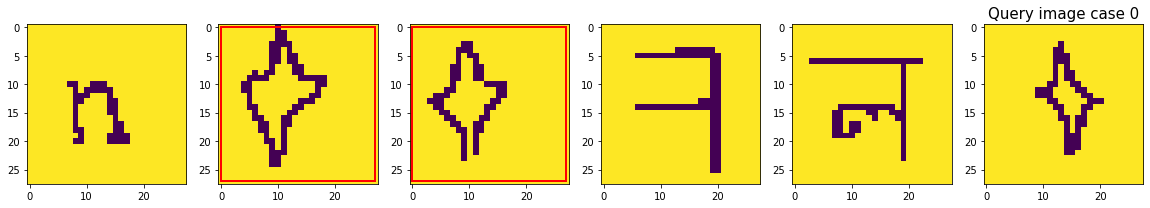

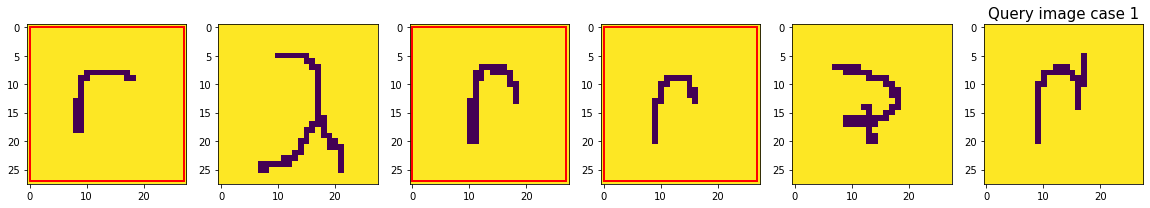

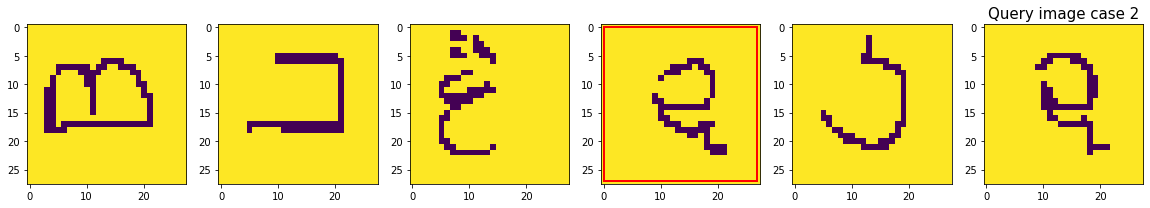

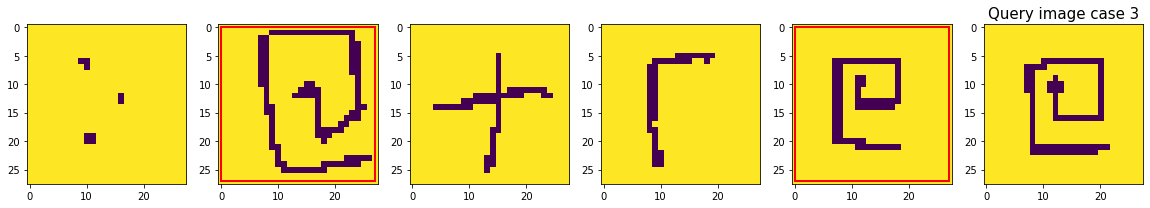

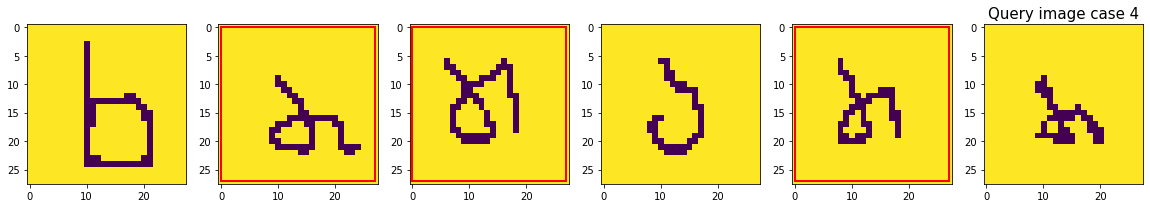

In [24]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


[plot_case(caseID,train_data,train_label) for caseID in range(5)]

In [ ]:
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

[plot_case(caseID,test_data,test_label) for caseID in range(5)]

torch.Size([6, 28, 28])

In [50]:
data = torch.FloatTensor(train_data)
all_images = data[0]
anchor_image = all_images[0]
trial_image = all_images[1]
x = torch.stack([anchor_image, trial_image], 0)

In [52]:
targets = torch.FloatTensor(train_label)
targets[0]

tensor([0., 1., 1., 0., 0.])

In [77]:
stacked_data = torch.FloatTensor(train_data)
stacked_targets = torch.FloatTensor(train_label)
data = torch.FloatTensor()
targets = torch.FloatTensor()

anchors = stacked_data[:,5]
for trial_images_index in range(5):
    trial_images = stacked_data[:, trial_images_index]
    case = torch.stack([anchors, trial_images], 1)
    data = torch.cat([data, case], 0)
    targets = torch.cat([targets, stacked_targets[:,trial_images_index]])
data.shape

torch.Size([50000, 2, 28, 28])

In [79]:
targets.shape

torch.Size([50000])

In [111]:
## Generate more than the reference image + trial image => [11000] here the images also either depict the same---or different---character, we don't use this now 
class PairsDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor()
        self.targets = torch.FloatTensor()
        stacked = torch.FloatTensor(data)
        stacked_targets = torch.FloatTensor(targets)
        anchors = stacked[:,5]
        for trial_images_index in range(5):
            trial_images = stacked[:, trial_images_index]
            case = torch.stack([anchors, trial_images], 1)
            self.data = torch.cat([self.data, case], 0)
            self.targets = torch.cat([self.targets, stacked_targets[:,trial_images_index]])
        self.targets = self.targets.unsqueeze(1)
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        return x, y
        
    def __len__(self):
        return len(self.data)

In [112]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [113]:
train_dataset=PairsDataset(train_data,train_label)
test_dataset=PairsDataset(test_data,test_label)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

print(len(train_dataset))

50000


In [114]:
## change it to triplet/consdjaslkdjasl loss
def loss_batch(model, loss_func, xb, yb, opt=None):
    
    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [115]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    logs = {}
    # liveloss = PlotLosses()
    
    for epoch in tqdm(range(epochs)):
        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            
            # forward
            # backward and optimize only if in training phase
            losses, nums = loss_batch(model, loss_func, xb, yb,opt)
            
            # statistics
            running_loss += losses * xb.size(0)
            sample_num+=nums
            
        train_loss = running_loss / sample_num
        logs['loss'] = train_loss
        
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            sample_num=0
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                
                # forward
                losses, nums = loss_batch(model, loss_func, xb, yb)
                
                # statistics
                running_loss += losses * xb.size(0)
                sample_num+=nums

            val_loss = running_loss / sample_num
            logs['val_loss'] = val_loss
        
        # liveloss.update(logs)
        # liveloss.draw()
            
        # print the results
        print(
            f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}', end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',end='\n')

In [116]:
## change to siamese network implementation
class Magic(nn.Module):
  def __init__(self):
    super(Magic, self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(2, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.2),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.2),
        nn.Flatten(),
        nn.Linear(1600, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.layers(x)
    return x

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [118]:
def get_mlpmodel():
  model = Magic()
  return model, optim.Adam(model.parameters())

In [119]:
model, opt = get_mlpmodel()

model.to(device)

fit(100, model, nn.BCELoss(), opt, train_loader, test_loader)

  1%|          | 1/100 [00:18<31:19, 18.98s/it]

EPOCH: 001/100 LOSS: 0.4826 VAL-LOSS: 0.3869


  2%|▏         | 2/100 [00:38<31:15, 19.14s/it]

EPOCH: 002/100 LOSS: 0.3720 VAL-LOSS: 0.3384


  3%|▎         | 3/100 [00:57<31:06, 19.24s/it]

EPOCH: 003/100 LOSS: 0.3425 VAL-LOSS: 0.3191


  4%|▍         | 4/100 [01:17<31:10, 19.48s/it]

EPOCH: 004/100 LOSS: 0.3273 VAL-LOSS: 0.3163


  5%|▌         | 5/100 [01:37<31:22, 19.81s/it]

EPOCH: 005/100 LOSS: 0.3167 VAL-LOSS: 0.3070


  6%|▌         | 6/100 [01:57<31:12, 19.92s/it]

EPOCH: 006/100 LOSS: 0.3106 VAL-LOSS: 0.3108


  7%|▋         | 7/100 [02:17<30:39, 19.78s/it]

EPOCH: 007/100 LOSS: 0.3038 VAL-LOSS: 0.3108


  8%|▊         | 8/100 [02:36<30:06, 19.64s/it]

EPOCH: 008/100 LOSS: 0.2964 VAL-LOSS: 0.3119


  9%|▉         | 9/100 [02:57<30:10, 19.89s/it]

EPOCH: 009/100 LOSS: 0.2915 VAL-LOSS: 0.2950


 10%|█         | 10/100 [03:17<29:52, 19.92s/it]

EPOCH: 010/100 LOSS: 0.2886 VAL-LOSS: 0.2921
